In [107]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from contourpy.util.data import simple
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm
from soupsieve.util import lower

In [108]:
plt.style.use('ggplot')
# plt.rcParams["figure.figsize"] = (12,3)

In [109]:
data = pd.read_csv('credit_data.csv')
data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [110]:
import bambi as bmb

credit_model = bmb.Model("Balance ~ Limit", data=data, family="gaussian")
credit_trace1 = credit_model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


In [111]:
credit_model

       Formula: Balance ~ Limit
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 520.015, sigma: 2622.7267)
            Limit ~ Normal(mu: 0.0, sigma: 0.498)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 459.1838)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [112]:
credit_model.backend.model

    sigma ~ HalfStudentT(4, 459)
Intercept ~ Normal(520, 2.62e+03)
    Limit ~ Normal(0, 0.498)
       mu ~ Deterministic(f(Limit, Intercept))
  Balance ~ Normal(mu, sigma)

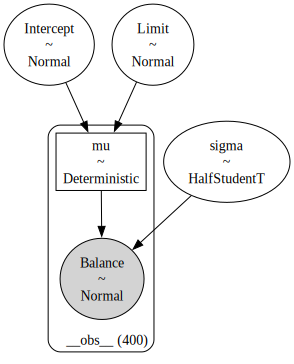

In [113]:
credit_model.graph()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'Limit'}>,
        <Axes: title={'center': 'Limit'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

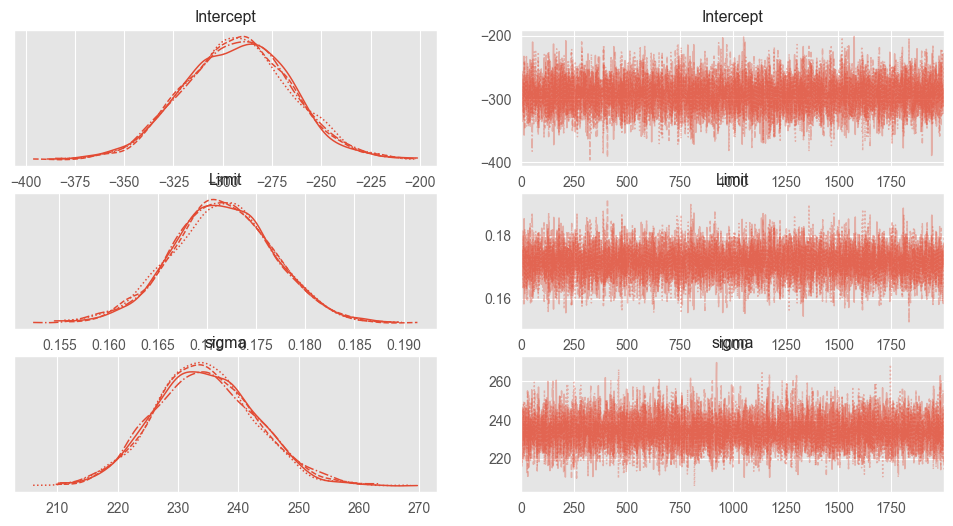

In [114]:
pm.plot_trace(credit_trace1)

In [115]:
pm.summary(credit_trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-292.739,27.205,-343.894,-243.308,0.242,0.172,12622.0,6583.0,1.0
Limit,0.172,0.005,0.162,0.181,0.000,0.000,12089.0,6364.0,1.0
sigma,234.450,8.376,218.777,250.048,0.077,0.055,12018.0,6377.0,1.0


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'Limit'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

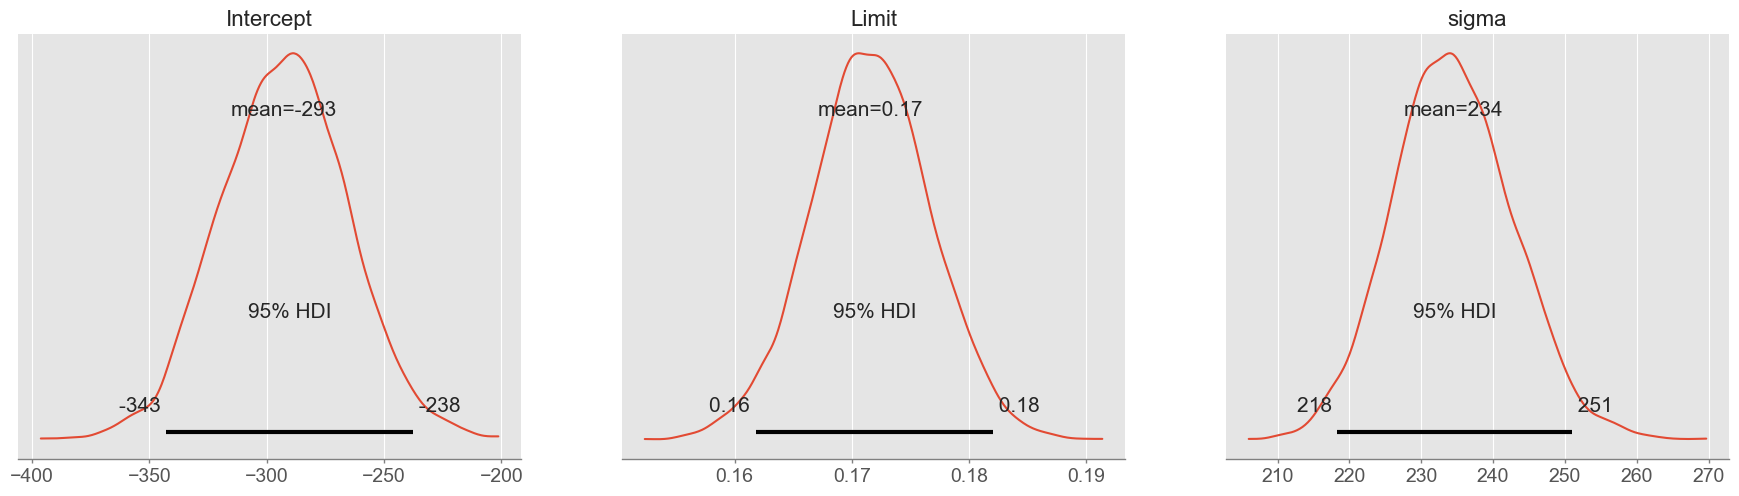

In [116]:
pm.plot_posterior(credit_trace1, hdi_prob=0.95)


Default computed for conditional variable: Limit


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='Limit', ylabel='Balance'>], dtype=object))

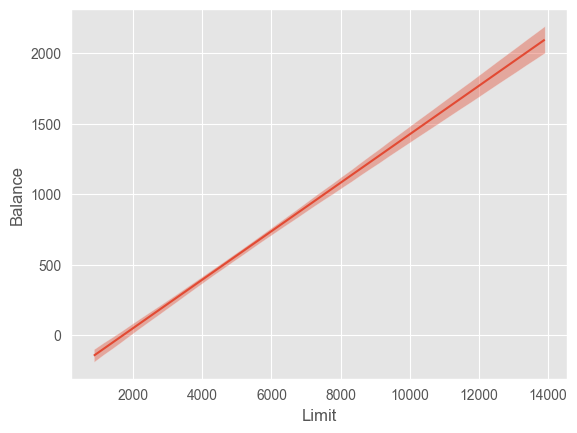

In [117]:
bmb.interpret.plot_predictions(credit_model, credit_trace1, ["Limit"], prob=0.95)

In [118]:
credit_model.predict(credit_trace1, kind="response")
ypred = az.extract(credit_trace1.posterior_predictive).Balance.values.T
ytrue = data.Balance.values

In [119]:
rmse = np.sqrt(np.mean((ypred - ytrue) ** 2))
print('RMSE:', rmse)

RMSE: 331.08294902592684


In [120]:
mae = np.mean(np.abs(ypred - ytrue))
print('MAE:', mae)

MAE: 260.7267774396903


In [121]:
pm.r2_score(ytrue, ypred)

r2        0.659109
r2_std    0.018687
dtype: float64

In [122]:
pred = credit_model.predict(credit_trace1, kind='response', data=pd.DataFrame({'Limit': [3000]}), inplace=False)
pred

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [123]:
pm.summary(pred.posterior_predictive, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Balance[0],221.992,234.064,-158.36,605.151,2.623,1.855,7969.0,7850.0,1.0


<Axes: title={'center': 'Balance\n0'}>

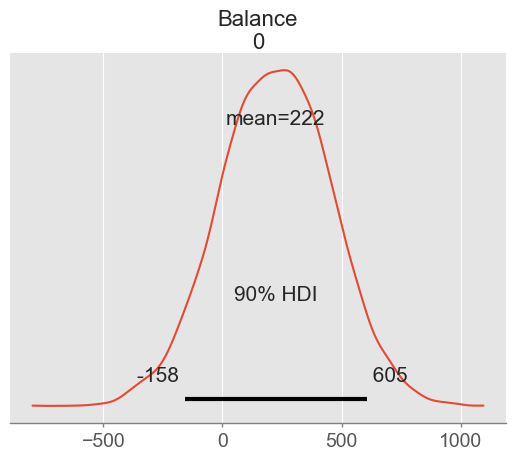

In [124]:
pm.plot_posterior(pred.posterior_predictive, hdi_prob=0.9)

In [125]:
x = data.Limit
y_observed = data.Balance
with pm.Model() as lin_reg_model:
    beta0 = pm.Normal('beta0', mu=y_observed.mean(), sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    sigma = pm.Exponential('sigma', lam=1 / 10)

    # y = pm.HalfNormal('y', mu=beta0 * x, sigma=sigma, observed=y_observed)
    y = pm.TruncatedNormal('y', mu=beta0 + beta1 * x, sigma=sigma, observed=y_observed, lower=0, upper=2000)

    credit_trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [126]:
pm.summary(credit_trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,486.347,10.043,466.894,504.029,0.177,0.125,3244.0,3122.0,1.0
beta1,0.026,0.006,0.016,0.037,0.000,0.000,3034.0,3027.0,1.0
sigma,452.601,20.678,416.291,492.810,0.373,0.264,3098.0,3204.0,1.0


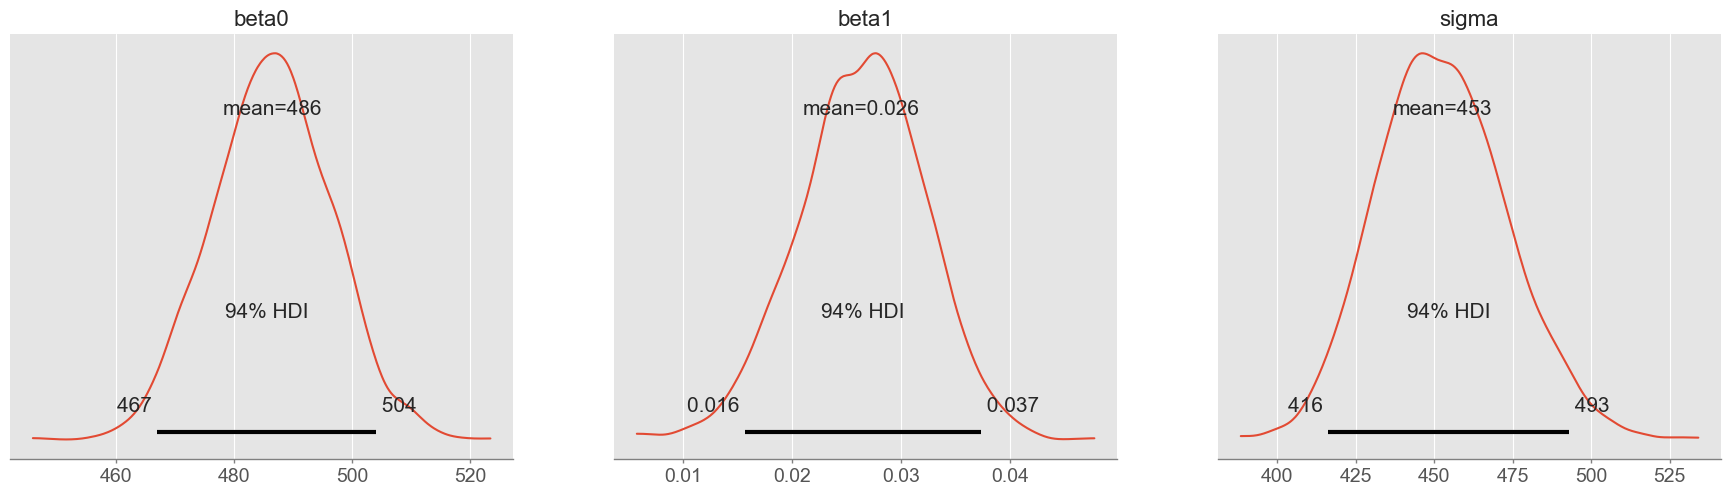

In [127]:
pm.plot_posterior(credit_trace2);

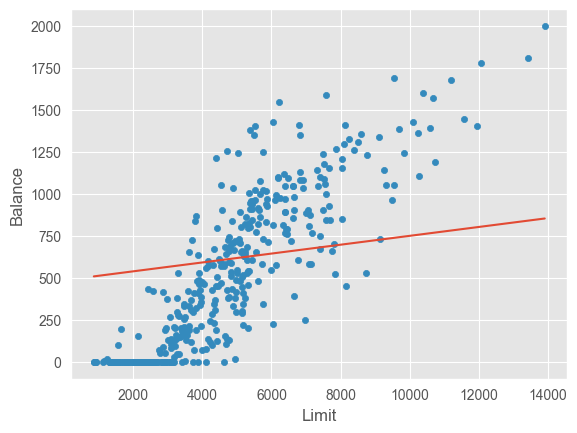

In [128]:
mean_beta0 = credit_trace2.posterior.beta0.mean().values
mean_beta1 = credit_trace2.posterior.beta1.mean().values
xrange = np.linspace(data.Limit.min(), data.Limit.max(), 1000)

data.plot.scatter(x="Limit", y="Balance")
plt.plot(xrange, mean_beta0 + mean_beta1 * xrange)

# Exercise 3

In [129]:
insurance_data = pd.read_csv('insurance.csv')

In [130]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [131]:
insurance_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Axes: xlabel='age', ylabel='charges'>

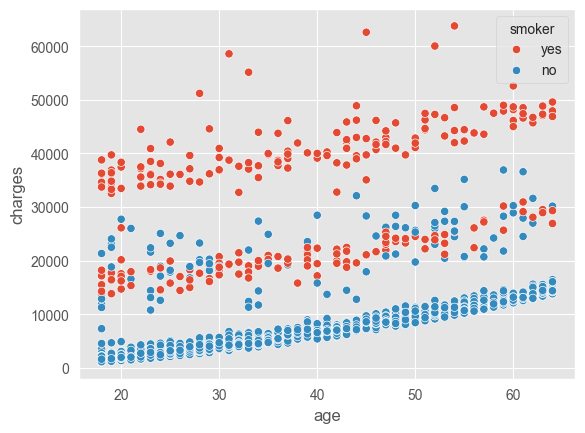

In [132]:
sns.scatterplot(x='age', y='charges', data=insurance_data, hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

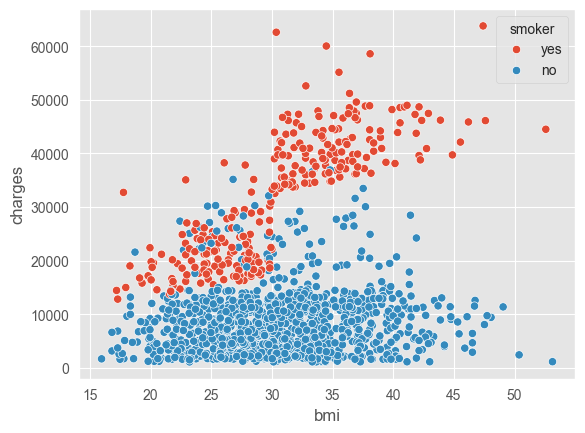

In [133]:
sns.scatterplot(x='bmi', y='charges', data=insurance_data, hue='smoker')

In [150]:
import bambi as bmb

insurance_model = bmb.Model("charges ~ age + bmi + smoker", data=insurance_data, family="gaussian")
insurance_trace1 = insurance_model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, bmi, smoker]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [151]:
insurance_model

       Formula: charges ~ age + bmi + smoker
        Family: gaussian
          Link: mu = identity
  Observations: 1338
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 13270.4223, sigma: 177379.9424)
            age ~ Normal(mu: 0.0, sigma: 2154.8123)
            bmi ~ Normal(mu: 0.0, sigma: 4964.595)
            smoker ~ Normal(mu: 0.0, sigma: 74994.9845)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 12105.485)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'smoker\nyes'}>, <Axes: >]], dtype=object)

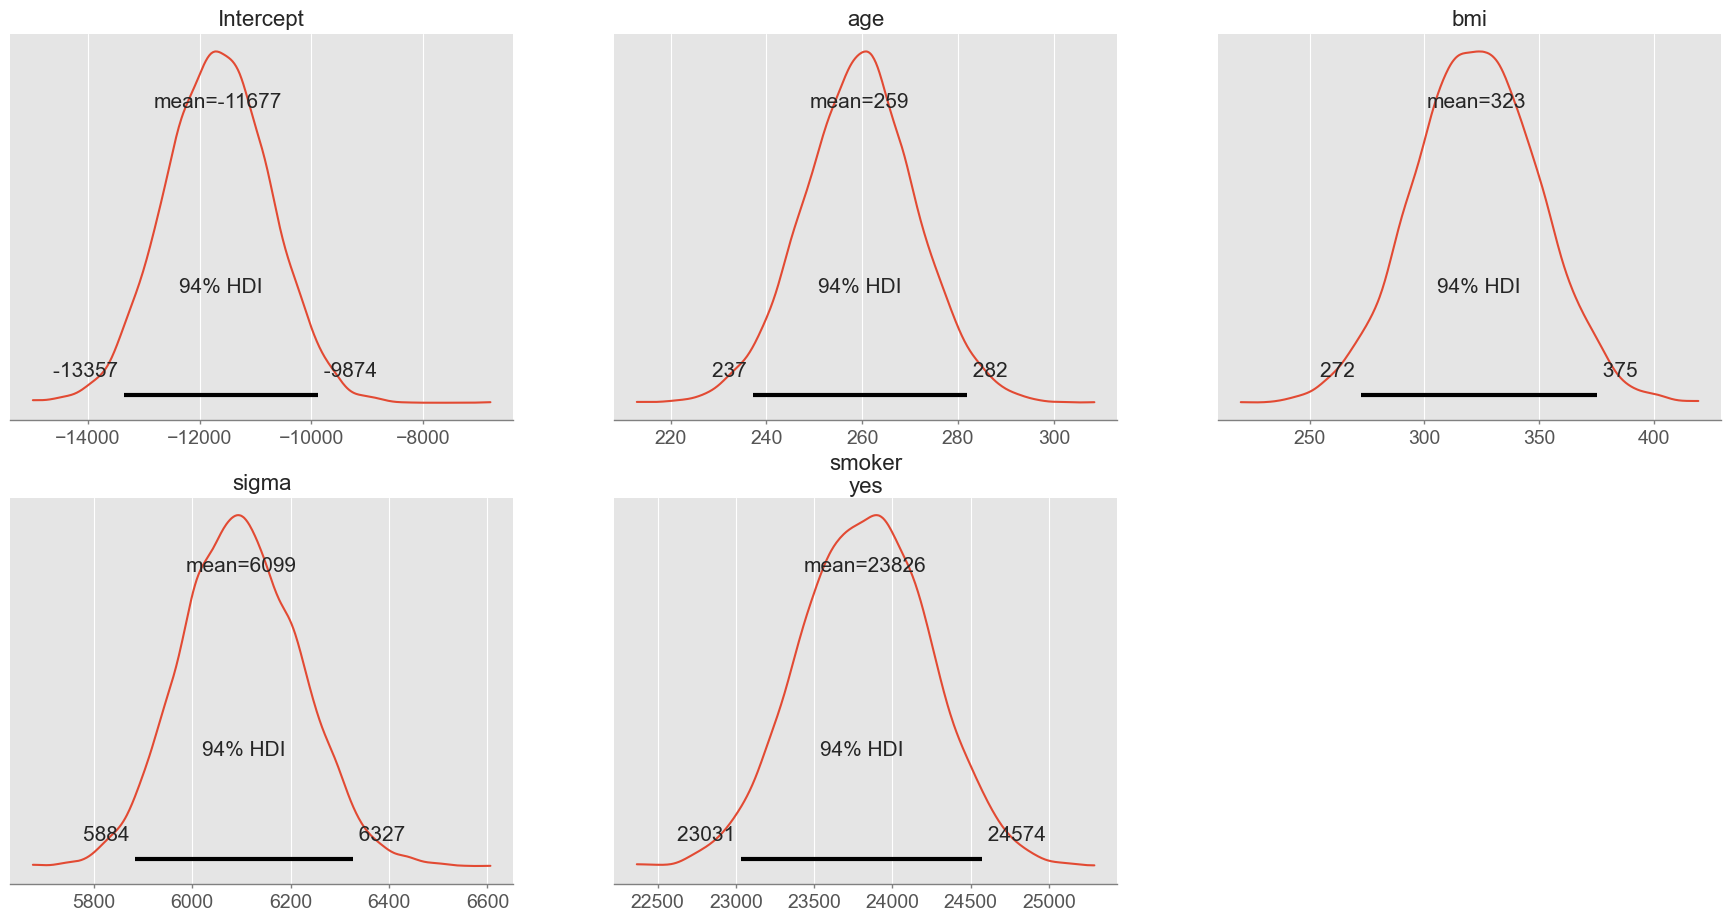

In [152]:
pm.plot_posterior(insurance_trace1)

In [153]:
pm.summary(insurance_trace1, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-11676.886,935.497,-13478.365,-9869.755,7.765,5.523,14540.0,6868.0,1.0
age,259.442,11.818,236.981,283.792,0.111,0.079,11389.0,6849.0,1.0
bmi,322.638,27.272,269.252,376.188,0.231,0.163,13950.0,7035.0,1.0
sigma,6098.524,120.007,5863.093,6325.763,0.995,0.704,14536.0,6636.0,1.0
smoker[yes],23825.927,412.114,23029.814,24633.161,3.446,2.437,14264.0,6232.0,1.0


In [154]:
insurance_model.predict(insurance_trace1, kind="response")
ypred = az.extract(insurance_trace1.posterior_predictive).charges.values.T
ytrue = insurance_data.charges.values

In [155]:
rmse = np.sqrt(np.mean((ypred - ytrue) ** 2))
print('RMSE:', rmse)

RMSE: 8619.335070631467


In [156]:
r_2 = pm.r2_score(ytrue, ypred)
print(r_2)

r2        0.664107
r2_std    0.010156
dtype: float64


In [157]:
insurance_model2 = bmb.Model("charges ~ age + sex + bmi + children + smoker + region", data=insurance_data,
                             family="gaussian")
insurance_trace2 = insurance_model2.fit(draws=2000, tune=2000)
pm.summary(insurance_trace2, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, sex, bmi, children, smoker, region]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-11922.114,1004.018,-13892.909,-10033.437,9.934,7.044,10211.0,5989.0,1.0
age,256.896,11.902,234.281,280.665,0.110,0.078,11718.0,6638.0,1.0
bmi,338.597,28.736,284.272,396.881,0.296,0.210,9442.0,6397.0,1.0
children,475.710,138.735,220.643,759.332,1.289,0.923,11579.0,6141.0,1.0
region[northwest],-347.848,478.602,-1270.617,607.774,5.176,4.112,8554.0,6402.0,1.0
region[southeast],-1033.644,483.280,-1997.572,-115.850,5.299,3.802,8323.0,6595.0,1.0
region[southwest],-959.174,476.657,-1928.145,-68.093,5.198,3.744,8420.0,6758.0,1.0
sex[male],-137.714,327.226,-801.710,465.697,3.134,3.434,10930.0,6194.0,1.0
sigma,6065.827,118.524,5832.071,6297.030,1.131,0.800,10927.0,6319.0,1.0
smoker[yes],23850.435,413.918,23050.061,24652.713,3.869,2.736,11429.0,6269.0,1.0


In [158]:
insurance_model.predict(insurance_trace2, kind="response")
ypred = az.extract(insurance_trace2.posterior_predictive).charges.values.T
ytrue = insurance_data.charges.values
rmse = np.sqrt(np.mean((ypred - ytrue) ** 2))
print('RMSE:', rmse)
r_2 = pm.r2_score(ytrue, ypred)
print(r_2)

RMSE: 8607.66780735448
r2        0.665161
r2_std    0.009992
dtype: float64


In [162]:
pred = insurance_model2.predict(insurance_trace2, kind="response", data=insurance_data, inplace=False)

var_e = pred.posterior.mu.var().values
np.sqrt(var_e)

10501.6395849814

In [163]:
var_p = pred.posterior_predictive.charges.var().values
np.sqrt(var_p)

12126.17154358569

In [164]:
var_a = var_p - var_e
np.sqrt(var_a)

6062.969761727253

In [165]:
print(f'Epistemic uncertainty: {var_e / var_p:.3f}')
print(f'Aleatory uncertainty: {var_a / var_p:.3f}')

Epistemic uncertainty: 0.750
Aleatory uncertainty: 0.250


In [170]:
insurance_model3 = bmb.Model("charges ~ age + sex + bmi + children + smoker + region + bmi:smoker", data=insurance_data,
                             family="gaussian")
insurance_trace3 = insurance_model3.fit(draws=2000, tune=2000)
pm.summary(insurance_trace3, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, sex, bmi, children, smoker, region, bmi:smoker]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2230.424,863.981,-3996.741,-646.736,10.361,7.459,6954.0,6087.0,1.0
age,263.735,9.361,245.877,281.892,0.101,0.072,8541.0,5929.0,1.0
bmi,23.788,25.617,-27.262,73.086,0.334,0.240,5867.0,5388.0,1.0
bmi:smoker[yes],1442.118,53.388,1336.913,1545.827,0.825,0.584,4187.0,5444.0,1.0
children,515.596,113.902,293.673,741.125,1.315,0.943,7503.0,5749.0,1.0
region[northwest],-584.816,379.512,-1314.577,149.472,5.146,3.722,5450.0,5981.0,1.0
region[southeast],-1216.304,379.195,-1957.455,-470.376,5.438,3.850,4858.0,5598.0,1.0
region[southwest],-1238.759,381.023,-1968.533,-500.842,5.565,3.935,4685.0,5675.0,1.0
sex[male],-502.165,268.076,-1030.461,21.682,2.957,2.223,8218.0,5744.0,1.0
sigma,4851.796,96.505,4663.279,5040.133,1.030,0.728,8780.0,5260.0,1.0


In [171]:
insurance_model3.predict(insurance_trace3, kind="response")
ypred = az.extract(insurance_trace3.posterior_predictive).charges.values.T
ytrue = insurance_data.charges.values
pm.r2_score(ytrue, ypred)

r2        0.757491
r2_std    0.007942
dtype: float64

# Exercise 4

In [174]:
ad_data = pd.read_csv('advertising.csv')
ad_data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


<Axes: xlabel='TV', ylabel='sales'>

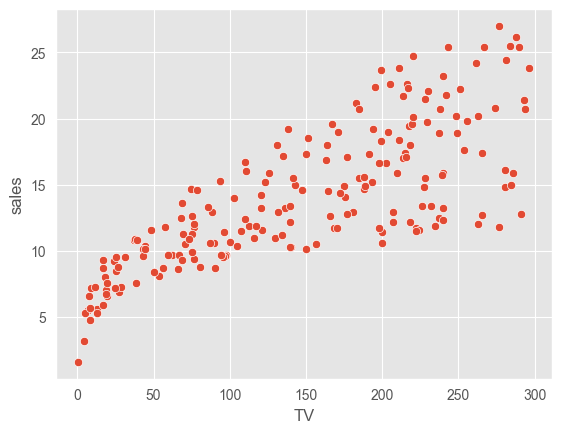

In [175]:
sns.scatterplot(x='TV', y='sales', data=ad_data)

<Axes: xlabel='radio', ylabel='sales'>

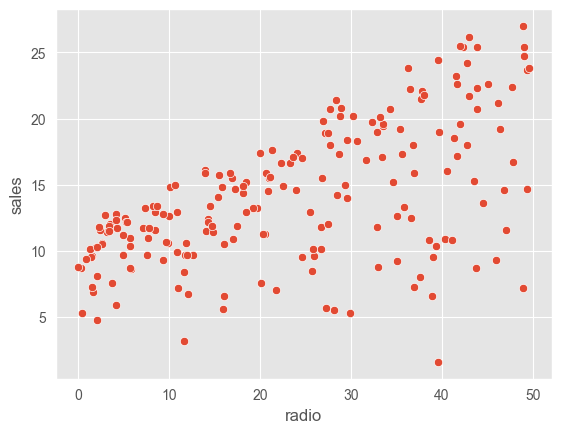

In [177]:
sns.scatterplot(x='radio', y='sales', data=ad_data)

<Axes: xlabel='newspaper', ylabel='sales'>

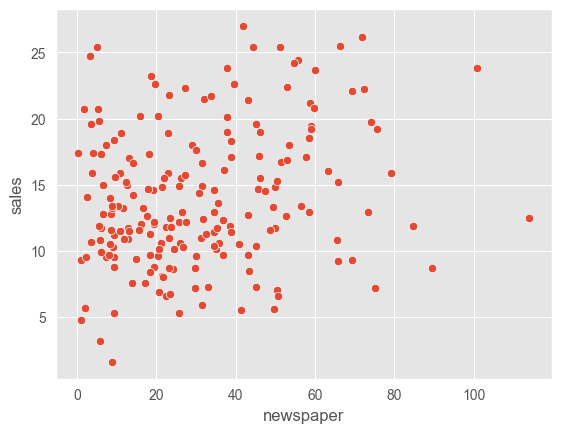

In [178]:
sns.scatterplot(x='newspaper', y='sales', data=ad_data)

<Axes: >

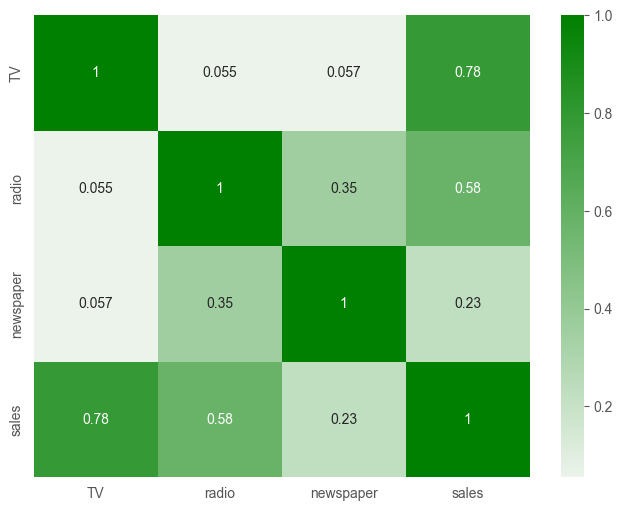

In [184]:
cm = sns.light_palette("green", as_cmap=True)
corr = ad_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap=cm)

In [188]:
ad_model1 = bmb.Model("sales ~ TV + radio + newspaper", data=ad_data, family="gaussian")
ad_trace1 = ad_model1.fit(draws=2000, tune=2000)
pm.summary(ad_trace1, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, newspaper]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.944,0.312,2.353,3.567,0.003,0.002,14287.0,7044.0,1.0
TV,0.046,0.001,0.043,0.049,0.000,0.000,14042.0,6401.0,1.0
newspaper,-0.001,0.006,-0.012,0.011,0.000,0.000,8607.0,6717.0,1.0
radio,0.189,0.009,0.171,0.205,0.000,0.000,8564.0,6835.0,1.0
sigma,1.695,0.086,1.535,1.868,0.001,0.001,11056.0,7009.0,1.0


In [194]:
ad_model1.predict(ad_trace1, kind="response")
ypred = az.extract(ad_trace1.posterior_predictive).sales.values.T
ytrue = ad_data.sales.values
pm.r2_score(ytrue, ypred)

r2        0.827006
r2_std    0.015967
dtype: float64

In [196]:
rmse = np.sqrt(np.mean((ypred-ytrue)**2))
print(f'RMSE: {rmse}')

RMSE: 2.3902058166398046


In [197]:
ad_model2 = bmb.Model('sales ~ TV + radio', data=ad_data, family="gaussian")
ad_trace2 = ad_model2.fit(draws=2000, tune=2000)
pm.summary(ad_trace2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.922,0.295,2.363,3.463,0.002,0.002,14474.0,6870.0,1.0
TV,0.046,0.001,0.043,0.048,0.000,0.000,13790.0,6300.0,1.0
radio,0.188,0.008,0.173,0.203,0.000,0.000,12134.0,6356.0,1.0
sigma,1.691,0.087,1.525,1.851,0.001,0.001,13755.0,6214.0,1.0


In [198]:
ad_model2.predict(ad_trace2, kind="response")
ypred = az.extract(ad_trace2.posterior_predictive).sales.values.T
ytrue = ad_data.sales.values
pm.r2_score(ytrue, ypred)

r2        0.827518
r2_std    0.015879
dtype: float64

In [205]:
rmse = np.sqrt(np.mean((ypred - ytrue) ** 2))
print(f'RMSE: {rmse}')

RMSE: 1.3392333636281322


In [210]:
ad_model3 = bmb.Model("sales ~ TV + radio + TV:radio", data=ad_data, family="gaussian")
ad_trace3 = ad_model3.fit(draws=2000, tune=2000)
pm.summary(ad_trace3, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, TV:radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.749,0.249,6.258,7.233,0.004,0.003,3275.0,3997.0,1.0
TV,0.019,0.002,0.016,0.022,0.000,0.000,3246.0,3768.0,1.0
TV:radio,0.001,0.000,0.001,0.001,0.000,0.000,3100.0,3434.0,1.0
radio,0.029,0.009,0.011,0.047,0.000,0.000,3268.0,3401.0,1.0
sigma,0.950,0.048,0.856,1.045,0.001,0.000,6819.0,5256.0,1.0


In [207]:
ad_model3.predict(ad_trace3, kind="response")
ypred = az.extract(ad_trace3.posterior_predictive).sales.values.T
ytrue = ad_data.sales.values
pm.r2_score(ytrue, ypred)

r2        0.938340
r2_std    0.006106
dtype: float64

In [208]:
rmse = np.sqrt(np.mean((ypred - ytrue) ** 2))
print(f'RMSE: {rmse}')

RMSE: 1.33797307510941
